<a href="https://colab.research.google.com/github/himanshu63867/Machine-Learning-Projects/blob/main/Retail_Store_Inventory_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problems the company faces**


 Stockouts — inventory insufficient for demand on a date → lost sales.

Overstock — inventory far exceeds demand → tied-up working capital.

Forecast errors — demand forecast deviates significantly from actual sales.

Ineffective promotions / pricing issues — discounts or competitor pricing not improving sales.

Seasonality & external factors — weather / holidays causing demand volatility.

# **Project objective**

Build a predictive early-warning model that flags rows (store × product × date) likely to experience any of the above problems before they happen, so operations/merchandising can act (restock, reprioritize promos, change price).

In [39]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

In [40]:
# Step 2: Load dataset
df = pd.read_csv("/content/retail_store_inventory.csv")
print("Shape:", df.shape)
print("Columns:", df.columns)

Shape: (73100, 15)
Columns: Index(['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
       'Competitor Pricing', 'Seasonality'],
      dtype='object')


In [41]:
# Step 3: Create Problem_Flag
# Define rules for problems
def create_problem(row):
    # Stockout problem
    if row['Units Sold'] > row['Inventory Level']:
        return 1
    # Overstock problem
    elif row['Inventory Level'] > row['Units Sold'] * 1.5:
        return 1
    # Forecasting problem
    elif abs(row['Demand Forecast'] - row['Units Sold']) / (row['Units Sold']+1) > 0.5:
        return 1
    else:
        return 0

In [42]:

df['Problem_Flag'] = df.apply(create_problem, axis=1)
print("Problem_Flag value counts:\n", df['Problem_Flag'].value_counts(normalize=True))

Problem_Flag value counts:
 Problem_Flag
1    0.667756
0    0.332244
Name: proportion, dtype: float64


In [43]:
# Step 5: Preprocessing
# Drop IDs and Date
drop_cols = ['Store ID','Product ID','Date']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# One-hot encode categoricals
df = pd.get_dummies(df, drop_first=True)

In [44]:
# Step 6: Train-test split (time-aware if Date exists)
X = df.drop(columns=['Problem_Flag'])
y = df['Problem_Flag']

# Simple split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (58480, 21) Test shape: (14620, 21)


In [45]:
# Step 7: Handle imbalance with SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("After SMOTE, positive rate:", y_train_res.mean())

After SMOTE, positive rate: 0.5


In [46]:
# Step 8: Train LightGBM
lgb_clf = lgb.LGBMClassifier(
    n_estimators=1200,
    learning_rate=0.01,
    num_leaves=64,
    max_depth=-1,
    colsample_bytree=0.8,
    subsample=0.9,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

lgb_clf.fit(X_train_res, y_train_res)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 39050, number of negative: 39050
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1502
[LightGBM] [Info] Number of data points in the train set: 78100, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.01, n_estimators=1200, n_jobs=-1, num_leaves=64,
               random_state=42, subsample=0.9)

In [47]:
# Step 9: Predict probabilities
y_prob_lgb = lgb_clf.predict_proba(X_test)[:,1]

# Step 10: Optimize threshold for accuracy
thresholds = np.arange(0.1, 0.9, 0.01)
acc_scores = []

for t in thresholds:
    preds = (y_prob_lgb >= t).astype(int)
    acc_scores.append(accuracy_score(y_test, preds))

best_t = thresholds[np.argmax(acc_scores)]
print("Best threshold:", best_t, "with accuracy:", max(acc_scores))

Best threshold: 0.4099999999999998 with accuracy: 0.9965116279069768


In [48]:
# Apply best threshold
y_pred_lgb = (y_prob_lgb >= best_t).astype(int)

# Step 11: Evaluate
print("\nLightGBM tuned performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lgb))
print(classification_report(y_test, y_pred_lgb, digits=4))


LightGBM tuned performance:
Accuracy: 0.9965116279069768
ROC AUC: 0.9999306816348785
              precision    recall  f1-score   support

           0     0.9957    0.9938    0.9947      4857
           1     0.9969    0.9978    0.9974      9763

    accuracy                         0.9965     14620
   macro avg     0.9963    0.9958    0.9961     14620
weighted avg     0.9965    0.9965    0.9965     14620



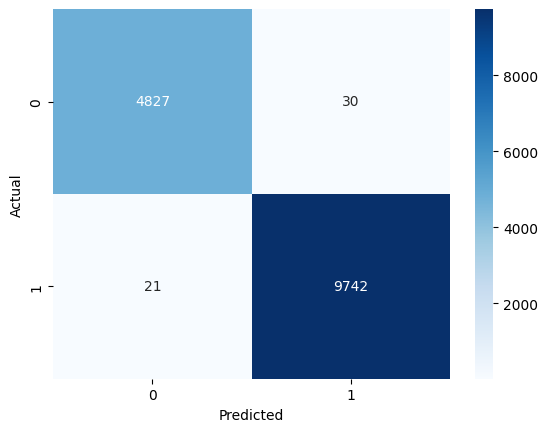

In [49]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lgb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [50]:
# Feature Importance
fi = pd.Series(lgb_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop features:")
display(fi.head(15))


Top features:


,0
Inventory Level,25198
Units Sold,24351
Demand Forecast,6404
Units Ordered,3518
Price,2340
Competitor Pricing,2297
Discount,1213
Category_Toys,917
Weather Condition_Rainy,831
Seasonality_Spring,821


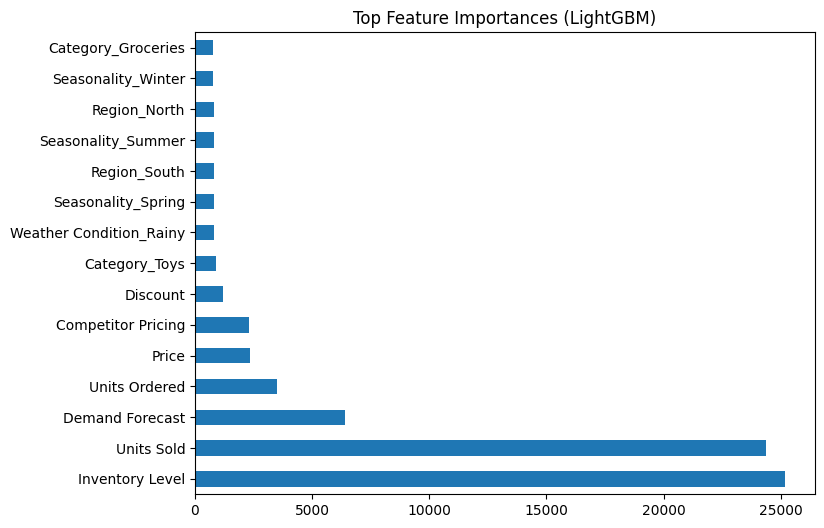

In [51]:
# Plot feature importance
fi.head(15).plot(kind='barh', figsize=(8,6))
plt.title("Top Feature Importances (LightGBM)")
plt.show()
